CUDA Available: False


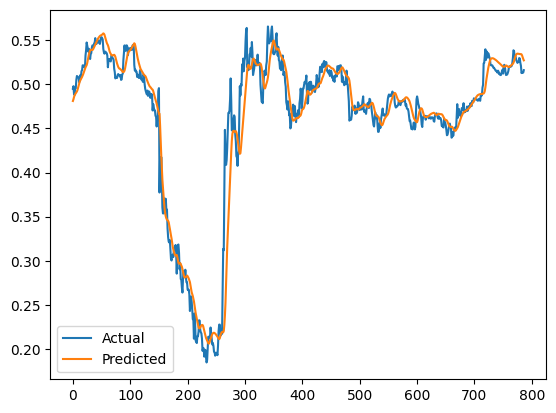

Final Portfolio Value: $100184.69
Total Trades Executed: 573
Winning Trades: 150
Losing Trades: 423
portfolio_series
2019-01-04 05:59:00    100000.00000
2019-01-04 06:00:00    100000.26316
2019-01-04 06:01:00    100000.87713
2019-01-04 06:02:00    100001.66661
2019-01-04 06:03:00    100002.10516
                           ...     
2019-01-04 19:01:00    100184.42165
2019-01-04 19:02:00    100183.89491
2019-01-04 19:03:00    100183.63154
2019-01-04 19:04:00    100184.50944
2019-01-04 19:05:00    100184.68504
Freq: min, Length: 787, dtype: float64
Final portfolio value: $100184.69
Hit Ratio: 26.18%
Strategy Gain: 0.18%


/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_2773/1641071034.py:307: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  index=pd.date_range(


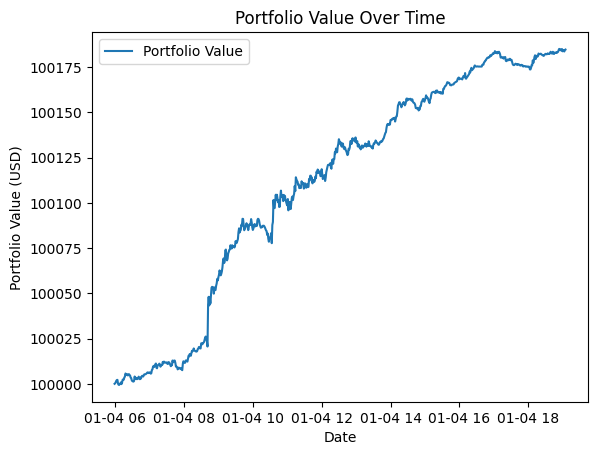

dataframe
                                0
2019-01-04 05:59:00  100000.00000
2019-01-04 06:00:00  100000.26316
2019-01-04 06:01:00  100000.87713
2019-01-04 06:02:00  100001.66661
2019-01-04 06:03:00  100002.10516
...                           ...
2019-01-04 19:01:00  100184.42165
2019-01-04 19:02:00  100183.89491
2019-01-04 19:03:00  100183.63154
2019-01-04 19:04:00  100184.50944
2019-01-04 19:05:00  100184.68504

[787 rows x 1 columns]
RangeIndex(start=0, stop=1, step=1)
Maximum Drawdown: -0.0135%
Sharpe Ratio: 2.58
Sortino Ratio: 0.00
timestamp: 1970-01-03 05:20:00


ValueError: Length of values (787) does not match length of index (47220)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

class BackTesting:
    def __init__(self, framework):
        self.framework = framework
        if framework == 'pytorch':
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print("CUDA Available:", torch.cuda.is_available())
            self.data_structure = self.initialize_pytorch_structure()
        else:
            self.data_structure = self.initialize_other_structure()

        # Trading and tracking parameters
        self.cash = 100000
        self.position = 0
        self.portfolio_value = []
        self.total_trades = 0
        self.winning_trades = 0
        self.losing_trades = 0
        self.buy_price = None
        self.decisions = []  # Store decisions for evaluation

    def initialize_pytorch_structure(self):
        return {"data": torch.tensor([])}

    def initialize_other_structure(self):
        return {"data": np.array([])}

    def load_data(self, file_path):
        self.data = pd.read_csv(file_path).head(4000)
        self.data['log_return'] = np.log(self.data['close'] / self.data['close'].shift(1))
        self.data['Next_High'] = self.data['high'].shift(-1)
        self.data['Return'] = self.data['close'].pct_change()
        self.data['Volatility'] = self.data['Return'].rolling(window=5).std()
        self.data['High_Low_Range'] = (self.data['high'] - self.data['low']) / self.data['low']
        self.data['Prev_Close_Rel_High'] = (self.data['close'].shift(1) - self.data['high']) / self.data['high']
        self.data.dropna(inplace=True)
        return self.data

    def prepare_data(self, time_step=60):
        self.time_step = time_step
        self.features = self.data[['open', 'high', 'low', 'close', 'volume', 'Return', 'Volatility', 'High_Low_Range', 'Prev_Close_Rel_High']].values
        self.targets = self.data['Next_High'].values
        self.feature_scaler = MinMaxScaler(feature_range=(0, 1))
        self.features = self.feature_scaler.fit_transform(self.features)
        self.target_scaler = MinMaxScaler(feature_range=(0, 1))
        self.targets = self.target_scaler.fit_transform(self.targets.reshape(-1, 1))

    def create_datasets(self):
        X, y = [], []
        for i in range(len(self.features) - self.time_step):
            X.append(self.features[i:i + self.time_step])
            y.append(self.targets[i + self.time_step])
        X, y = np.array(X), np.array(y)
        split = int(0.8 * len(X))
        self.X_train = torch.tensor(X[:split], dtype=torch.float32)
        self.X_test = torch.tensor(X[split:], dtype=torch.float32)
        self.y_train = torch.tensor(y[:split], dtype=torch.float32)
        self.y_test = torch.tensor(y[split:], dtype=torch.float32)

    def build_model(self):
        class LSTMModel(nn.Module):
            def __init__(self, input_size, hidden_size, output_size, num_layers, device):
                super(LSTMModel, self).__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.device = device
                self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
                self.fc = nn.Linear(hidden_size, output_size)

            def forward(self, x):
                h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
                c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
                out, _ = self.lstm(x, (h0, c0))
                out = self.fc(out[:, -1, :])
                return out

        self.model = LSTMModel(input_size=self.X_train.shape[2], hidden_size=100, output_size=1, num_layers=2, device=self.device).to(self.device)
            
    def train_model(self, epochs, batch_size, learning_rate, patience):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        train_loader = torch.utils.data.DataLoader(dataset=list(zip(self.X_train, self.y_train)), batch_size=batch_size, shuffle=True)
        best_val_loss = float('inf')
        epochs_without_improvement = 0
    
        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0
            for features, labels in train_loader:
                features, labels = features.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / len(train_loader)
            self.model.eval()
            with torch.no_grad():
                X_val = self.X_test.to(self.device)
                y_val = self.y_test.to(self.device)
                val_loss = criterion(self.model(X_val), y_val).item()
    
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                torch.save(self.model.state_dict(), 'lstm_model.pth')
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    break

    def evaluate_model(self):
        self.model.eval()
        with torch.no_grad():
            X_test = self.X_test.to(self.device)
            predictions = self.model(X_test).cpu().numpy()
            y_test = self.y_test.numpy()
        self.predictions = self.target_scaler.inverse_transform(predictions)
        self.y_test = self.target_scaler.inverse_transform(y_test)
        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.legend()
        plt.show()

    def make_decision(self, timestamp, prediction, action, current_price):
        """Log each decision with placeholders for actual prices."""
        self.decisions.append({
            "timestamp": timestamp,
            "prediction": prediction,
            "action": action,
            "current_price": current_price,
            "actual_price": None  # Placeholder for future actual price
        })
        #print(f"Decision logged: {timestamp}, {action} at {current_price}, predicted: {prediction}")
    def fetch_actual_price(self, timestamp):
        print('timestamp:', timestamp)
    
        # Convert the input timestamp to string for comparison
        timestamp_str = timestamp.strftime('%Y-%m-%d %H:%M:%S')
    
        try:
            # Convert tensor to a NumPy array
            numpy_array = self.X_test.numpy()
    
            # Extract timestamps from the tensor (assuming they are in the first column)
            # Adjust this indexing based on how your data is structured
            original_timestamps = numpy_array[:, 0, 0]  # Adjust if necessary
    
            # Reshape the array to 2D (flatten first two dimensions)
            reshaped_array = numpy_array.reshape(-1, numpy_array.shape[-1])  # Shape will be (787*60, 9)
    
            # Create a DataFrame from the reshaped array
            column_names = ['open', 'high', 'low', 'close', 'volume', 'Return', 'Volatility', 'High_Low_Range', 'Prev_Close_Rel_High']  # Adjust names as needed
            X_test_df = pd.DataFrame(reshaped_array, columns=column_names)
    
            # Add the original timestamps to the DataFrame
            X_test_df['timestamp'] = pd.to_datetime(original_timestamps, unit='s')  # Adjust if necessary
            print(X_test_df)
    
            # Check if the timestamp exists in the DataFrame
            actual_row = X_test_df[X_test_df['timestamp'] == timestamp]
    
            if not actual_row.empty:
                actual_price = actual_row['close'].values[0]
                print('Actual Price:', actual_price)  # Debug print for actual price
                return actual_price
            else:
                print(f"Timestamp {timestamp} not found in the dataset.")
                return None
    
        except KeyError:
            print(f"Timestamp {timestamp} not found in the dataset.")
            return None
        



    def evaluate_decisions(self):
        for decision in self.decisions:
            actual_price = self.fetch_actual_price(decision["timestamp"])
            decision["actual_price"] = actual_price
            #print(f"Evaluated Decision at {decision['timestamp']}: predicted {decision['prediction']}, "
             #     f"actual {decision['actual_price']}, action: {decision['action']}")


    def optimized_trading_strategy(self):
        """Implements trading logic with event-based decision logging."""
        self.initial_cash = 100000  
        position = 0  
        cash = self.initial_cash
        self.portfolio_value = []  
        trades = []  
        buy_threshold = 0.00
        sell_threshold = 0.00
        position_size_factor = 0.1
        trading_days = len(self.X_test)  
        self.start_price = self.data['close'].iloc[int(0.8 * len(self.data))]
        self.end_price = self.data['close'].iloc[-1]
        buy_price = None
        if not isinstance(self.data.index, pd.DatetimeIndex):
            try:
                self.data.index = pd.to_datetime(self.data.index, unit='m')  # Adjust 'ns' or 's' as needed
            except Exception as e:
                print("Conversion to datetime failed:", e)
                return

              
        for i in range(trading_days):
            current_price = self.data['close'].iloc[int(0.8 * len(self.data)) + i]
            predicted_high = self.predictions[i][0]
            buy_signal = current_price < predicted_high * (1 + buy_threshold)
            sell_signal = (current_price > (buy_price * sell_threshold)) if buy_price else False
            # Ensure 'timestamp' is parsed as datetime and set it as the index
            current_index = int(0.8 * len(self.data)) + i
            
            # Retrieve the timestamp at the current index
            current_timestamp = self.data.index[current_index]
            
            # Now you have the exact timestamp
            #print(f"Current timestamp at index {current_index}: {current_timestamp}")

    
            if position == 0 and buy_signal:
                # Buy decision
                amount_to_invest = position_size_factor * cash
                shares_to_buy = amount_to_invest // current_price
                cash -= shares_to_buy * current_price
                position += shares_to_buy
                buy_price = current_price
                self.make_decision(current_timestamp, predicted_high, "buy", current_price)  # Log buy event
    
            elif position > 0 and sell_signal:
                # Sell decision
                trade_value = position * current_price
                cash += trade_value
                profit_or_loss = trade_value - (position * buy_price)
                trades.append(profit_or_loss)
                if profit_or_loss > 0:
                    self.winning_trades  += 1
                else:
                    self.losing_trades += 1
                self.total_trades += 1
                position = 0
                buy_price = None
                self.make_decision(current_timestamp, predicted_high, "sell", current_price)  # Log sell event
    
                # Optionally: Initiate short if strategy allows
                amount_to_invest = position_size_factor * cash
                shares_to_short = amount_to_invest // current_price
                cash += shares_to_short * current_price  # Short proceeds added to cash
                position -= shares_to_short
    
            elif position < 0 and buy_signal:
                # Buy to cover short position
                trade_value = abs(position) * current_price
                cash -= trade_value
                profit_or_loss = -trade_value
                trades.append(profit_or_loss)
                if profit_or_loss > 0:
                    self.winning_trades += 1
                else:
                    self.losing_trades += 1
                self.total_trades += 1
                position = 0
    
                # Re-buy
                amount_to_invest = position_size_factor * cash
                shares_to_buy = amount_to_invest // current_price
                cash -= shares_to_buy * current_price
                position += shares_to_buy
                buy_price = current_price
                self.make_decision(current_timestamp, predicted_high, "buy", current_price)  # Log re-buy event
    
            # Update portfolio value for the day
            self.portfolio_value.append(cash + position * current_price)
    
        final_portfolio_value = self.portfolio_value[-1]
        print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
        print(f"Total Trades Executed: {self.total_trades}")
        print(f"Winning Trades: {self.winning_trades}")
        print(f"Losing Trades: {self.losing_trades}")

    


    
    def calculate_performance_metrics(self):
            import ffn
            # Prepare the data
            self.data['date'] = pd.to_datetime(self.data['timestamp'])
            self.data.set_index('date', inplace=True)

        
            # Create portfolio_series with the appropriate frequency
            portfolio_series = pd.Series(
                self.portfolio_value,
                index=pd.date_range(
                    start=self.data.index[-len(self.portfolio_value)],
                    periods=len(self.portfolio_value),
                    freq='T'  # Set the appropriate frequency
                )
            )
            print('portfolio_series')
            print(portfolio_series)
        
            # Calculate hit ratio and strategy gain
            hit_ratio = (self.winning_trades / self.total_trades) * 100 if self.total_trades > 0 else 0
            strategy_gain = (self.portfolio_value[-1] - self.cash) / self.cash * 100
        
            print(f"Final portfolio value: ${self.portfolio_value[-1]:.2f}")
            print(f"Hit Ratio: {hit_ratio:.2f}%")
            print(f"Strategy Gain: {strategy_gain:.2f}%")
        
            # Plot portfolio value over time
            plt.plot(portfolio_series.index, portfolio_series, label='Portfolio Value')
            plt.xlabel('Date')
            plt.ylabel('Portfolio Value (USD)')
            plt.title('Portfolio Value Over Time')
            plt.legend()
            plt.show()
        
            # Convert the Series to a DataFrame for ffn
            portfolio_df = pd.DataFrame(portfolio_series)
            print('dataframe')
            print(portfolio_df)
            print(portfolio_df.columns)
            portfolio_df['returns'] = portfolio_df[0].pct_change()
            max_drawdown = ffn.calc_max_drawdown(portfolio_series)
            print(f"Maximum Drawdown: {max_drawdown:.4%}" if max_drawdown is not None else "Maximum Drawdown: N/A")
        
            # Calculate Sharpe Ratio
            minute_returns = portfolio_df['returns'].dropna()
            risk_free_rate = 0.01 / (252 * 390) 
            excess_returns = minute_returns - risk_free_rate
            
            # Calculate annualized Sharpe Ratio
            sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(390)  # Annualized for minute returns
            print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

            # sortino
            downside_returns = excess_returns[excess_returns < 0]
            downside_deviation = np.std(downside_returns) * np.sqrt(252 * 390)  # Annualized downside deviation
            
            # Calculate annualized Sortino Ratio
            sortino_ratio = (excess_returns.mean() / downside_deviation)
            print(f"Sortino Ratio: {sortino_ratio:.2f}")




        
        





    def run_backtest(self, data_file_path):
        self.load_data(data_file_path)
        self.prepare_data(time_step=60)
        self.create_datasets()
        self.build_model()
        self.train_model(epochs=1, batch_size=32, learning_rate=0.001, patience=8)
        self.evaluate_model()
        self.optimized_trading_strategy()
        self.calculate_performance_metrics()
        self.evaluate_decisions()  # Evaluate logged decisions

# Usage
if __name__ == '__main__':
    bt = BackTesting('pytorch')
    bt.run_backtest('../../EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv')
